In [1]:
# Imports from __future__ in case we're running Python 2
from __future__ import division, print_function
from __future__ import absolute_import, unicode_literals

import math
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Data from SAL benchmarks

In [44]:
my_dtype = np.dtype('i4, i4, f4')
TIME_LIMIT=12*60*60

def result2num(x):
    "convert 'timeout' into TIME_LIMIT number of seconds"
    if x.strip() == "timeout":
        return TIME_LIMIT
    else:
        return x
    
def sort_by_num_nodes(n1, n2, d):
    assert(len(n1) == len(n2) and len(n2) == len(d))
    nn = n1 + n2
    ret = []
    for j in range(np.max(nn)+1):
        for a,b,s in zip(n1,n2,d):
            if a+b == j:
                ret.append([j+1, s])  # append no. relays + receivers + 1 source, time taken
    return ret

# return pairs (num_nodes, time)
def by_num_nodes(n1, n2, d):
    return zip(n1+n2, d)
    
a_nrl, a_nrc, a_t = np.loadtxt("time_affirm_12h.log", dtype=my_dtype, unpack=True
                              , comments='#', delimiter=','
                              , converters = {2: result2num})
a_by_nodes = by_num_nodes(a_nrl, a_nrc, a_t)

r_nrl, r_nrc, r_t = np.loadtxt("time_rushby_12h.log", dtype=my_dtype, unpack=True
                              , comments='#', delimiter=','
                              , converters = {2: result2num})
r_by_nodes = by_num_nodes(r_nrl, r_nrc, r_t)

def by_max_time(nds):
    """
    Return array of pairs (x, y) where y is the maximum time
    to solve among the data points with x number of nodes
    """
    maxt = dict()
    for x,y in nds:
        if x not in maxt or (x in maxt and maxt[x] < y):
            maxt[x] = y
    return list(maxt.iteritems())

amaxtime = by_max_time(a_by_nodes)
rmaxtime = by_max_time(r_by_nodes)



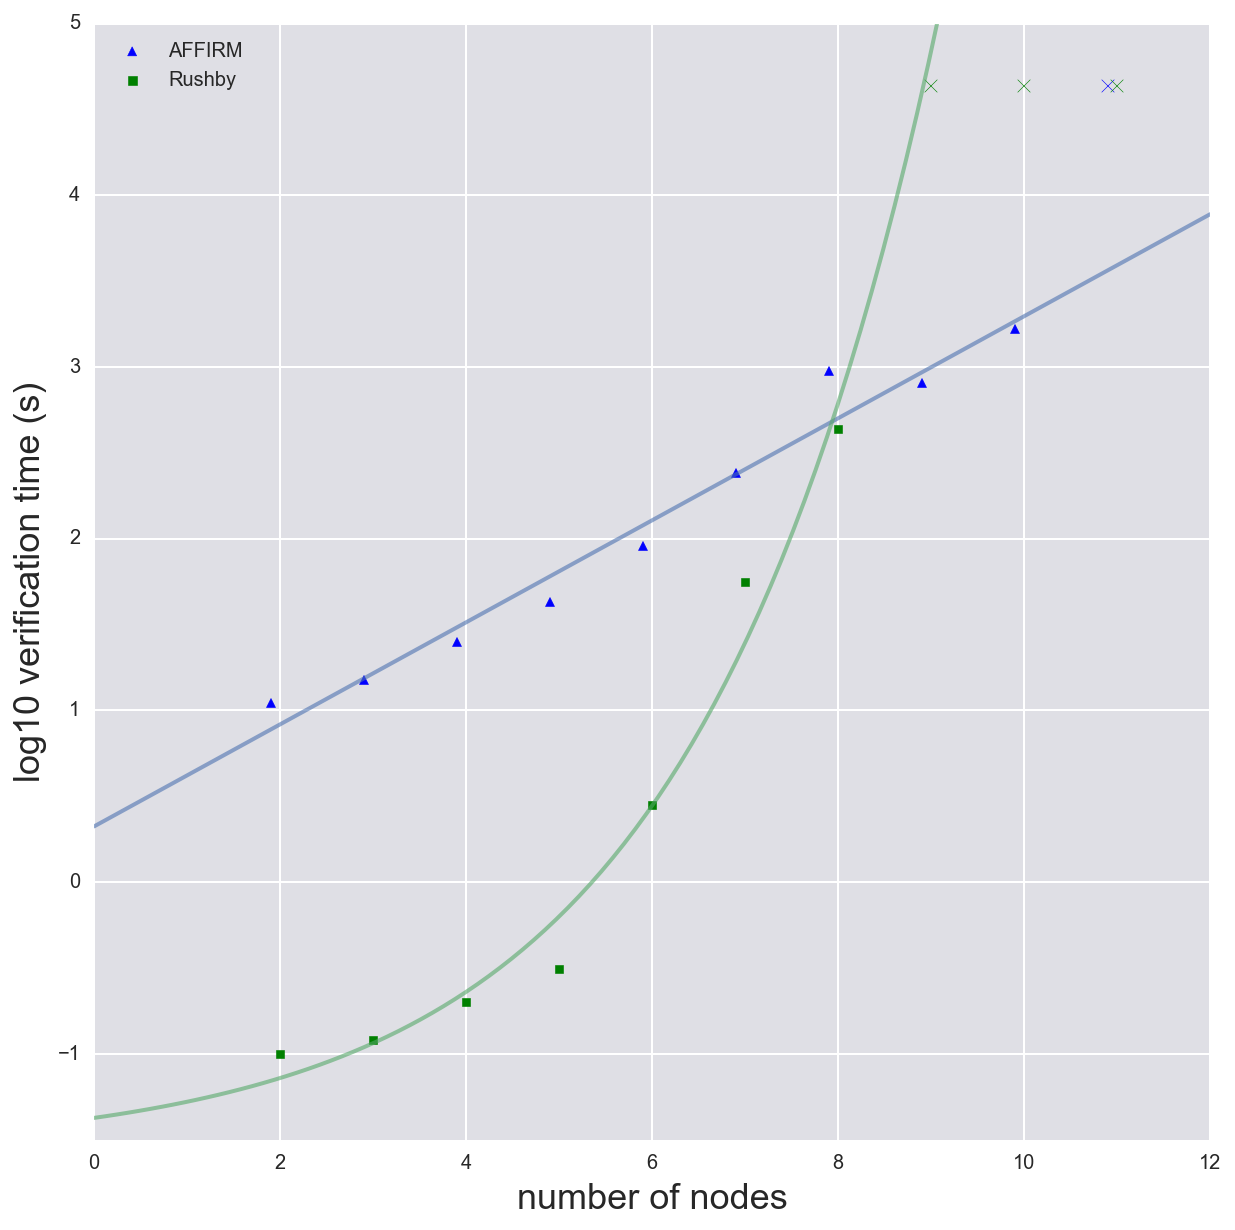

In [77]:
def mk_scatter(data1, data2, limit=TIME_LIMIT, afunc=None, rfunc=None):
    """make a scatter plot of number of nodes vs. time"""
    
    #params
    nps = 100  # number of points for plotting curve fit
    sep = 0.1  # x-axis separation of two data sets
    eps = 1.0  # for floating point compare
    xlim = [0,12]
    ylim = [-1.5, 5]
    timeout_marker_size = 40
    acolor = 'blue'  # affirm color
    rcolor = 'green'   # rushby color
    def timein(w): return w < limit-eps

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    # data1

    x,y = zip(*[ (z-sep, math.log10(w)) for (z,w) in data1 if timein(w)])
    ax.scatter(x, y, marker='^', color=acolor, label='AFFIRM')
    if afunc is not None:
        a_popt, a_pcov = curve_fit(afunc, x, y)
        lx = np.linspace(xlim[0], xlim[1], nps)
        fx = [ afunc(z, *a_popt) for z in lx ]
        ax.plot(lx, fx, alpha=0.6)
    x,y = zip(*[ (z-sep, math.log10(w)) for (z,w) in data1 if not timein(w) ])
    ax.scatter(x, y, timeout_marker_size, marker='x', color=acolor)

    # data2

    x,y = zip(*[ (z, math.log10(w)) for (z,w) in data2 if timein(w)])
    ax.scatter(x, y, marker='s', color=rcolor, label='Rushby')
    if rfunc is not None:
        r_popt, r_pcov = curve_fit(rfunc, x, y)
        fx = [ rfunc(z, *r_popt) for z in lx ]
        ax.plot(lx, fx, alpha=0.6)
    x,y = zip(*[ (z, math.log10(w)) for (z,w) in data2 if not timein(w) ])
    ax.scatter(x, y, timeout_marker_size, marker='x', color=rcolor)

    # fit curves to the data sets
    
    

   
    # time limit line
    #ax.plot([2,12], [math.log10(TIME_LIMIT), math.log10(TIME_LIMIT)], linestyle='--', color='red')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('number of nodes')
    ax.set_ylabel('log10 verification time (s)')

    # fixup the legend
    from collections import OrderedDict
    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), numpoints=1, loc=2)  # upper left
    return fig

    
def afunc(x, a, b):
    return a*x + b

def rfunc(x, a, b, c):
    return c + b*np.exp(a*x)

fig = mk_scatter(amaxtime, rmaxtime, afunc=afunc, rfunc=rfunc)
fig.savefig("benchmark_affirm_vs_rushby_curves.pdf")

[ 0.35562368  0.0216865 ]


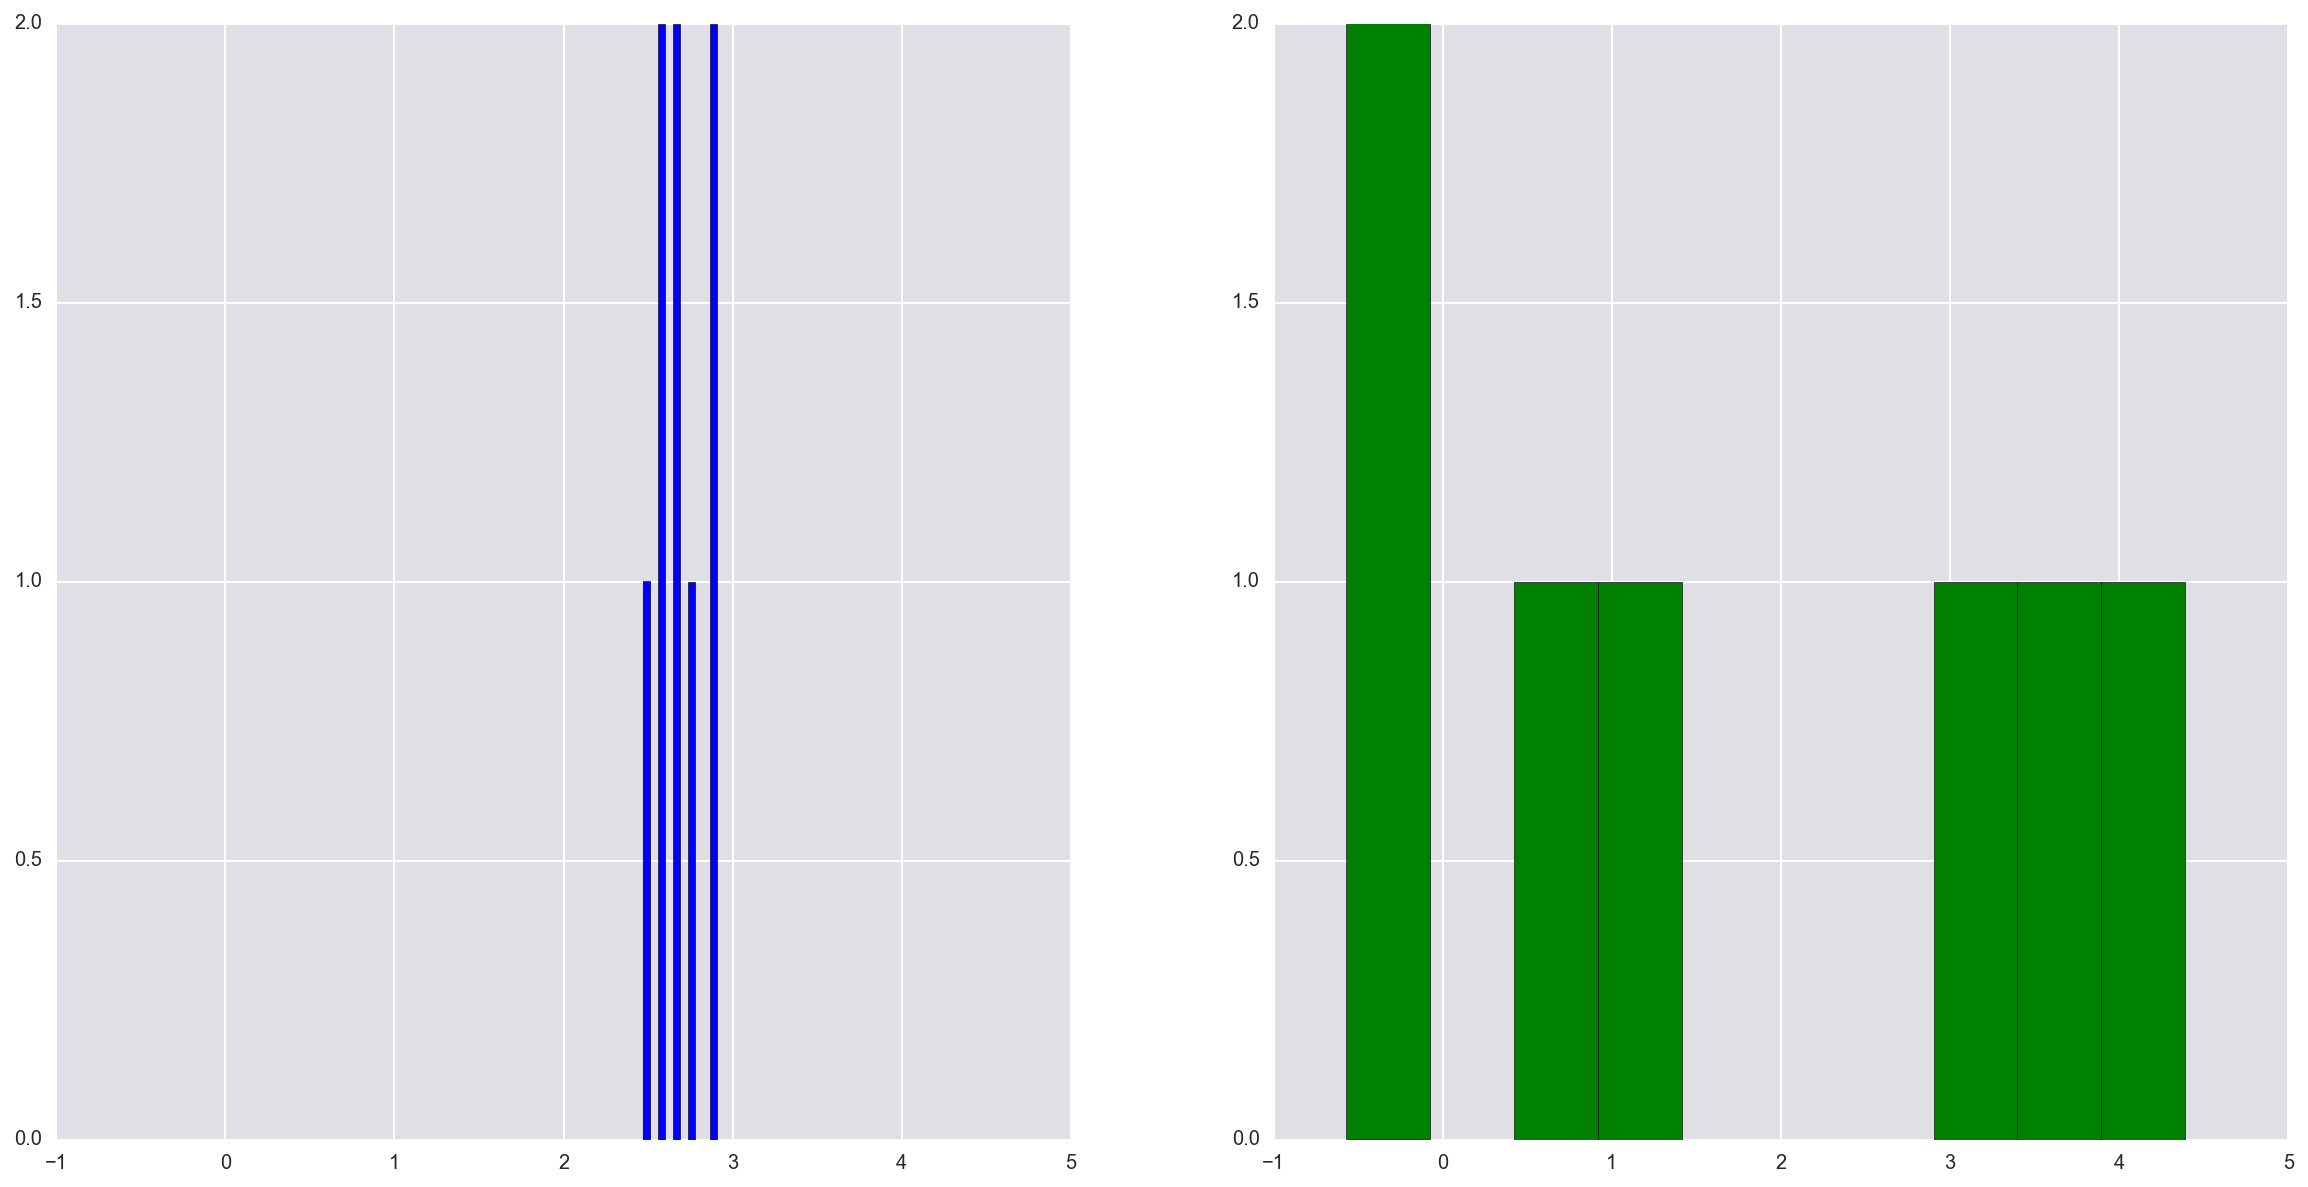

In [38]:
# distribution of times when num nodes is fixed

num_nodes = 10

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
data = [ math.log10(w) for (z,w) in a_by_nodes if z == num_nodes and timein(w) ]
n, bins, patches = ax1.hist(data, facecolor=acolor)

ax2 = fig.add_subplot(122, sharex=ax1)
data = [ math.log10(w) for (z,w) in r_by_nodes if z == num_nodes and timein(w)]
n, bins, patches = ax2.hist(data, facecolor=rcolor)

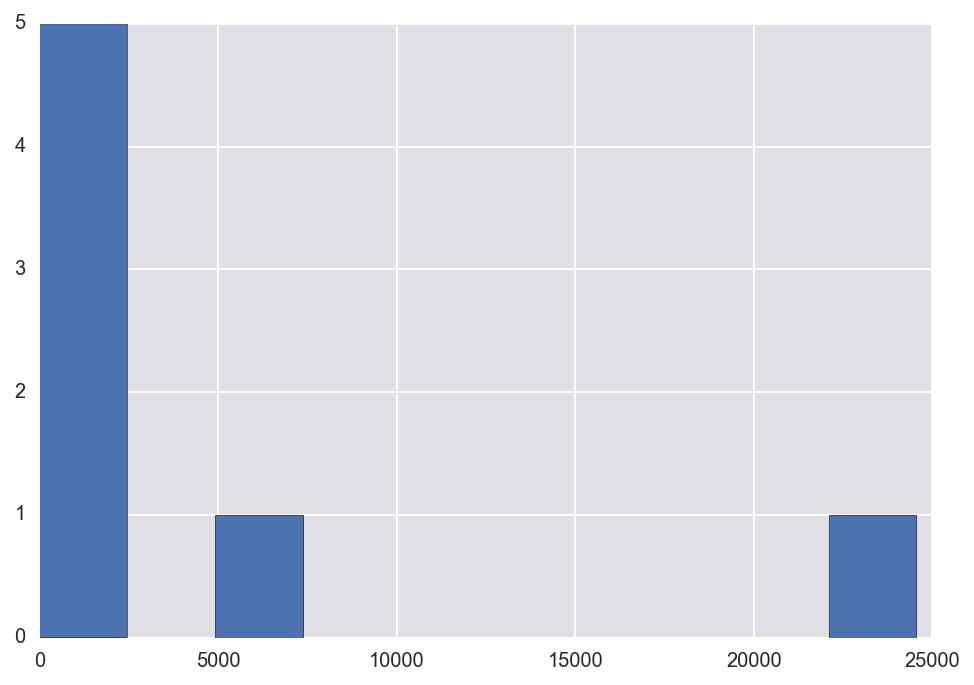